In [3]:
# Import library utama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import modul dari sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Import TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers, utils, models

# Supaya warning tidak mengganggu tampilan
import warnings
warnings.filterwarnings('ignore')

# Setup agar penggunaan GPU optimal
tf.config.experimental.enable_memory_growth = True

# Set random seed untuk hasil yang konsisten
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Cek versi dan ketersediaan GPU
print(f"Versi TensorFlow: {tf.__version__}")
print(f"GPU terdeteksi: {tf.config.list_physical_devices('GPU')}")


Versi TensorFlow: 2.18.0
GPU terdeteksi: []


In [2]:
# Load CIFAR-10 dataset
(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create subset untuk training cepat
subset_size = 5000
test_size = 1000

# Stratified sampling
indices_train = []
indices_test = []

for class_id in range(10):
    class_indices_train = np.where(y_train_full.flatten() == class_id)[0]
    class_indices_test = np.where(y_test_full.flatten() == class_id)[0]

    indices_train.extend(np.random.choice(class_indices_train,
                                        size=min(subset_size//10, len(class_indices_train)),
                                        replace=False))
    indices_test.extend(np.random.choice(class_indices_test,
                                       size=min(test_size//10, len(class_indices_test)),
                                       replace=False))

X_train = X_train_full[indices_train]
y_train = y_train_full[indices_train]
X_test = X_test_full[indices_test]
y_test = y_test_full[indices_test]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Classes: {class_names}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training set: (5000, 32, 32, 3)
Test set: (1000, 32, 32, 3)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


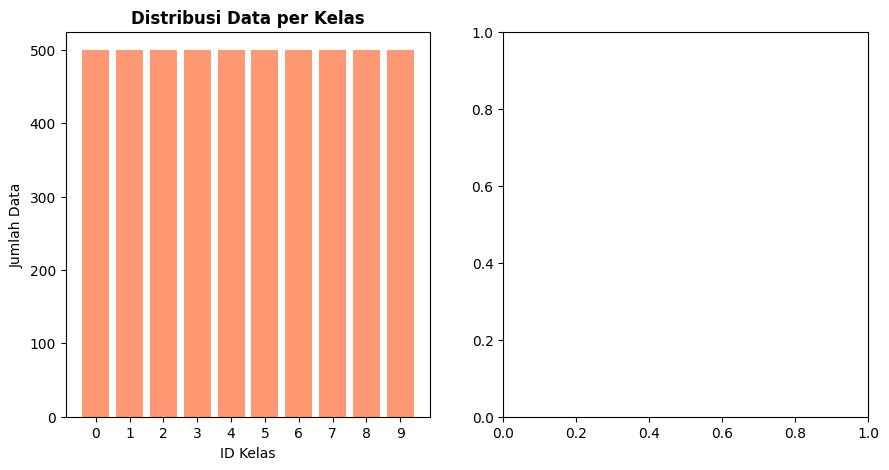

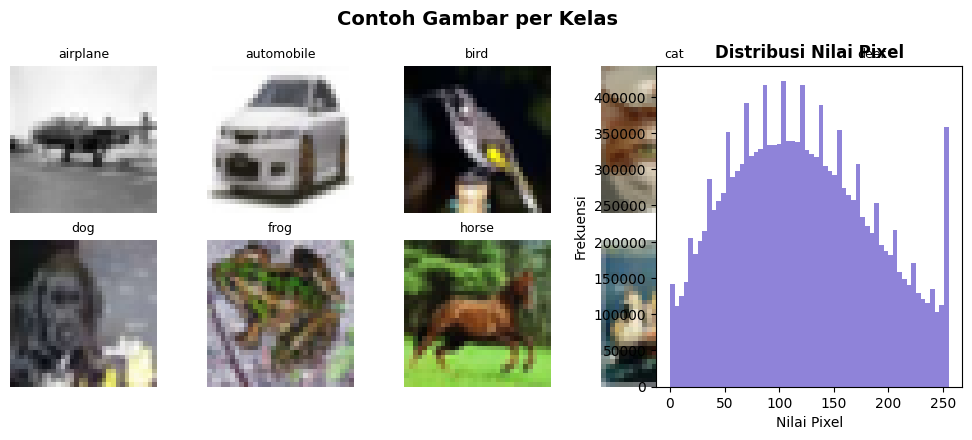

Statistik Data CIFAR-10:
Rentang nilai pixel: [0, 255]
Rata-rata pixel: 120.70
Standar deviasi pixel: 64.07


In [7]:
# Eksplorasi Data CIFAR-10

# Setup ukuran figure utama
plt.figure(figsize=(16, 5))

# Plot 1: Distribusi jumlah data per kelas
plt.subplot(1, 3, 1)
labels_unique, labels_count = np.unique(y_train, return_counts=True)
plt.bar(labels_unique, labels_count, color='coral', alpha=0.8)
plt.title('Distribusi Data per Kelas', fontweight='bold')
plt.xlabel('ID Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(ticks=range(10), labels=range(10))

# Plot 2: Contoh gambar dari masing-masing kelas
plt.subplot(1, 3, 2)
fig_samples, axs_samples = plt.subplots(2, 5, figsize=(10, 4))
fig_samples.suptitle('Contoh Gambar per Kelas', fontsize=14, fontweight='bold')

for i in range(10):
    sample_idx = np.where(y_train == i)[0][0]
    ax = axs_samples[i // 5, i % 5]
    ax.imshow(X_train[sample_idx])
    ax.set_title(f'{class_names[i]}', fontsize=9)
    ax.axis('off')

plt.tight_layout()

# Plot 3: Distribusi nilai pixel
plt.subplot(1, 3, 3)
plt.hist(X_train.ravel(), bins=60, color='slateblue', alpha=0.75)
plt.title('Distribusi Nilai Pixel', fontweight='bold')
plt.xlabel('Nilai Pixel')
plt.ylabel('Frekuensi')

# Tampilkan semua plot
plt.tight_layout()
plt.show()

# Statistik Data
print("Statistik Data CIFAR-10:")
print(f"Rentang nilai pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Rata-rata pixel: {X_train.mean():.2f}")
print(f"Standar deviasi pixel: {X_train.std():.2f}")


=== Hasil Normalisasi & Encoding ===
Range pixel setelah normalisasi: [0.000, 1.000]
Shape label setelah one-hot encoding: (5000, 10)


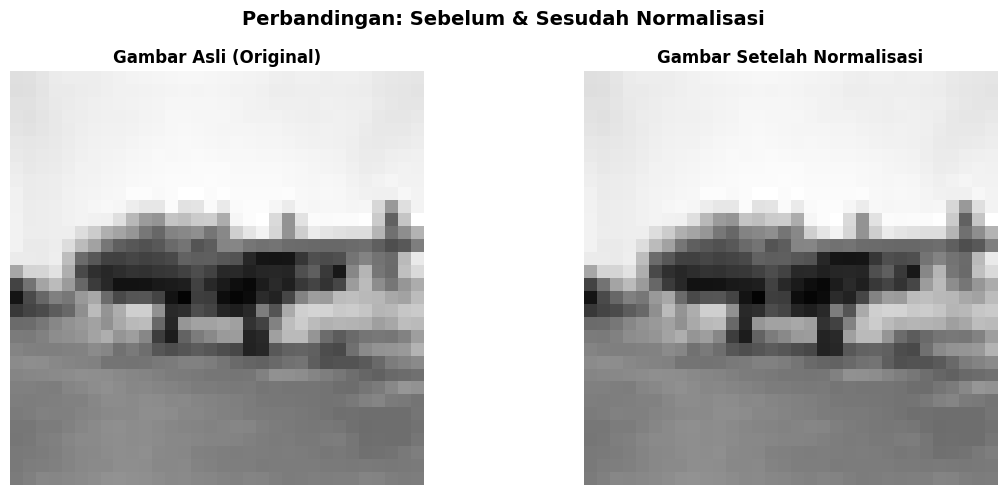

In [8]:
# Normalisasi nilai pixel (0 - 1)
X_train_scaled = X_train.astype(np.float32) / 255.0
X_test_scaled = X_test.astype(np.float32) / 255.0

# Flatten label dan one-hot encoding
y_train_flattened = y_train.flatten()
y_test_flattened = y_test.flatten()

y_train_onehot = utils.to_categorical(y_train_flattened, num_classes=10)
y_test_onehot = utils.to_categorical(y_test_flattened, num_classes=10)

# Cek hasil normalisasi & encoding
print("=== Hasil Normalisasi & Encoding ===")
print(f"Range pixel setelah normalisasi: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Shape label setelah one-hot encoding: {y_train_onehot.shape}")

# Visualisasi gambar sebelum & sesudah normalisasi
fig_preprocess, (ax_orig, ax_norm) = plt.subplots(1, 2, figsize=(12, 5))

# Gambar original
ax_orig.imshow(X_train[0])
ax_orig.set_title('Gambar Asli (Original)', fontsize=12, fontweight='bold')
ax_orig.axis('off')

# Gambar setelah normalisasi
ax_norm.imshow(X_train_scaled[0])
ax_norm.set_title('Gambar Setelah Normalisasi', fontsize=12, fontweight='bold')
ax_norm.axis('off')

fig_preprocess.suptitle('Perbandingan: Sebelum & Sesudah Normalisasi', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Total parameter model: 315,722


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

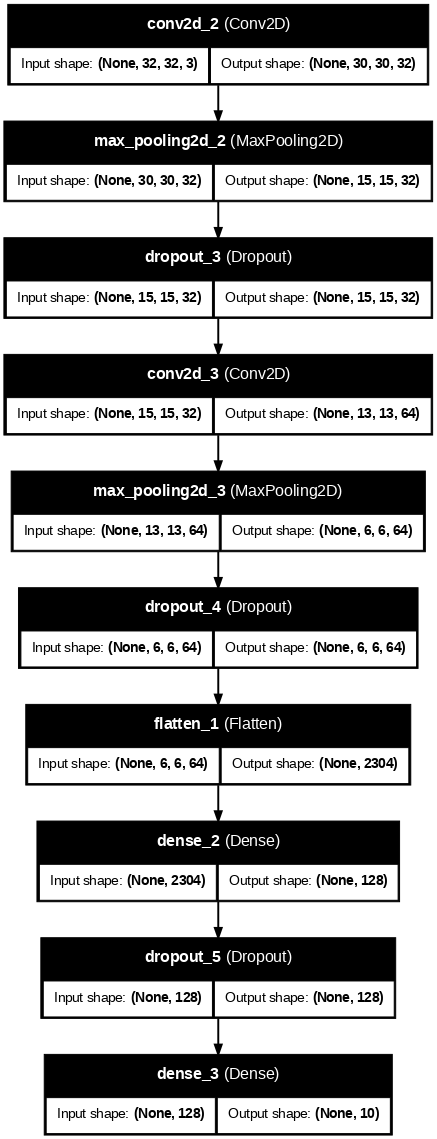

In [10]:
# Fungsi untuk membuat arsitektur CNN sederhana
def create_simple_cnn():
    cnn_model = models.Sequential([
        # Block 1
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(rate=0.25),

        # Block 2
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(rate=0.25),

        # Classifier head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(10, activation='softmax')
    ])

    # Compile model dengan optimizer Adam
    cnn_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        metrics=['accuracy']
    )

    return cnn_model

# Inisialisasi model
cnn_model = create_simple_cnn()

# Print info model
print(f"Total parameter model: {cnn_model.count_params():,}")

# Summary model
cnn_model.summary()

# Visualisasi arsitektur model
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True, dpi=70)


In [11]:
# Setup daftar callback untuk training
my_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

# Proses training model CNN
training_history = cnn_model.fit(
    X_train_scaled, y_train_onehot,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_scaled, y_test_onehot),
    callbacks=my_callbacks,
    verbose=1
)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.1361 - loss: 2.2754 - val_accuracy: 0.2220 - val_loss: 2.0864 - learning_rate: 0.0050
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2452 - loss: 2.0257 - val_accuracy: 0.3710 - val_loss: 1.8105 - learning_rate: 0.0050
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3064 - loss: 1.8884 - val_accuracy: 0.3530 - val_loss: 1.8411 - learning_rate: 0.0050
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.3220 - loss: 1.8019 - val_accuracy: 0.3840 - val_loss: 1.6914 - learning_rate: 0.0050
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.3552 - loss: 1.7322 - val_accuracy: 0.4220 - val_loss: 1.6269 - learning_rate: 0.0050
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3699 - loss: 1.6964 - val_accuracy: 0.4220 - val_loss: 1.5978 - learning_rate: 0.0050
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3828 - loss: 1.6531 - val_ac

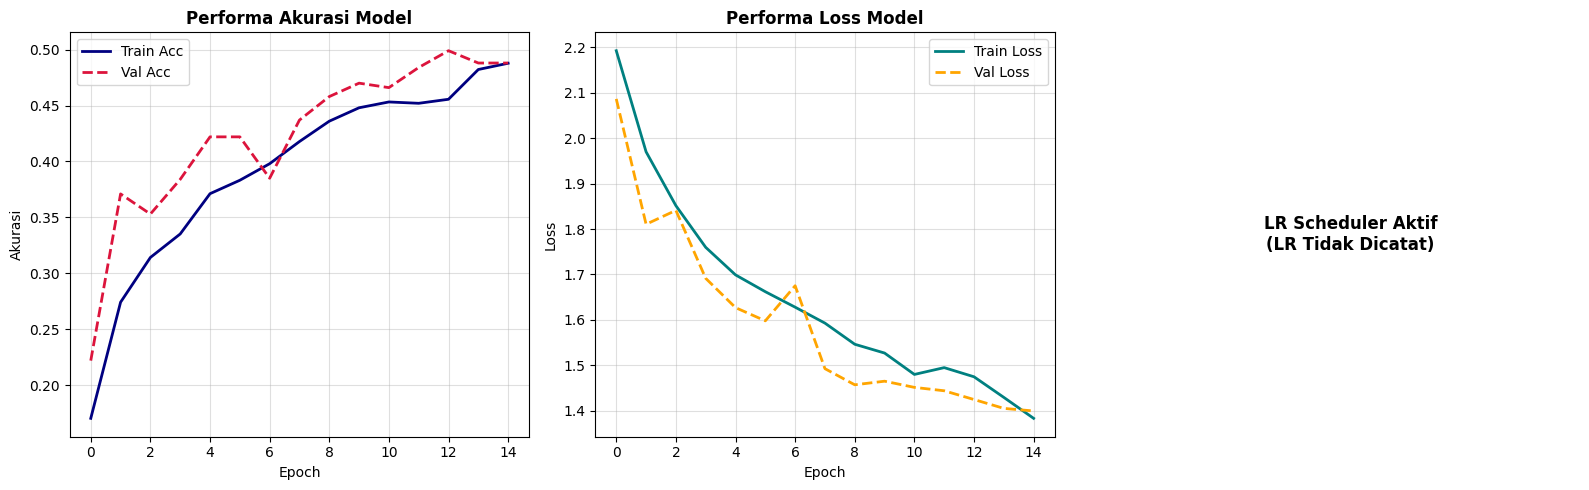

In [12]:
# Visualisasi hasil training model
plt.figure(figsize=(16, 5))

# Plot akurasi
plt.subplot(1, 3, 1)
plt.plot(training_history.history['accuracy'], color='navy', linestyle='-', linewidth=2, label='Train Acc')
plt.plot(training_history.history['val_accuracy'], color='crimson', linestyle='--', linewidth=2, label='Val Acc')
plt.title('Performa Akurasi Model', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(alpha=0.4)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(training_history.history['loss'], color='teal', linestyle='-', linewidth=2, label='Train Loss')
plt.plot(training_history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Val Loss')
plt.title('Performa Loss Model', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.4)

# Plot learning rate jika tersedia
plt.subplot(1, 3, 3)
if 'lr' in training_history.history:
    plt.plot(training_history.history['lr'], color='green', linewidth=2)
    plt.title('Perubahan Learning Rate', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'LR Scheduler Aktif\n(LR Tidak Dicatat)', ha='center', va='center', fontsize=12, fontweight='bold')
    plt.axis('off')

# Layout rapih
plt.tight_layout()
plt.show()


In [13]:
# Prediksi pada data uji
y_proba_pred = cnn_model.predict(X_test_scaled, verbose=0)
y_pred_class = np.argmax(y_proba_pred, axis=1)

# Hitung metrik evaluasi
acc_score = accuracy_score(y_test_flattened, y_pred_class)
prec_score = precision_score(y_test_flattened, y_pred_class, average='weighted')
rec_score = recall_score(y_test_flattened, y_pred_class, average='weighted')
f1_score_val = f1_score(y_test_flattened, y_pred_class, average='weighted')
roc_auc_val = roc_auc_score(y_test_onehot, y_proba_pred, average='weighted', multi_class='ovr')

# Cetak hasil evaluasi
print("="*65)
print("HASIL EVALUASI MODEL CNN")
print("="*65)
print(f"Akurasi   : {acc_score:.4f} ({'Mantap' if acc_score > 0.8 else 'Bagus' if acc_score > 0.7 else 'Cukup'})")
print(f"Presisi   : {prec_score:.4f} ({'Mantap' if prec_score > 0.8 else 'Bagus' if prec_score > 0.7 else 'Cukup'})")
print(f"Recall    : {rec_score:.4f} ({'Mantap' if rec_score > 0.8 else 'Bagus' if rec_score > 0.7 else 'Cukup'})")
print(f"F1-Score  : {f1_score_val:.4f} ({'Mantap' if f1_score_val > 0.8 else 'Bagus' if f1_score_val > 0.7 else 'Cukup'})")
print(f"AUC-ROC   : {roc_auc_val:.4f} ({'Sangat Baik' if roc_auc_val > 0.85 else 'Baik' if roc_auc_val > 0.75 else 'Cukup'})")

# Simpan metrik untuk analisis lanjutan
eval_metrics = {
    'accuracy': acc_score,
    'precision': prec_score,
    'recall': rec_score,
    'f1_score': f1_score_val,
    'auc_roc': roc_auc_val
}

HASIL EVALUASI MODEL CNN
Akurasi   : 0.4990 (Cukup)
Presisi   : 0.5183 (Cukup)
Recall    : 0.4990 (Cukup)
F1-Score  : 0.5013 (Cukup)
AUC-ROC   : 0.8822 (Sangat Baik)


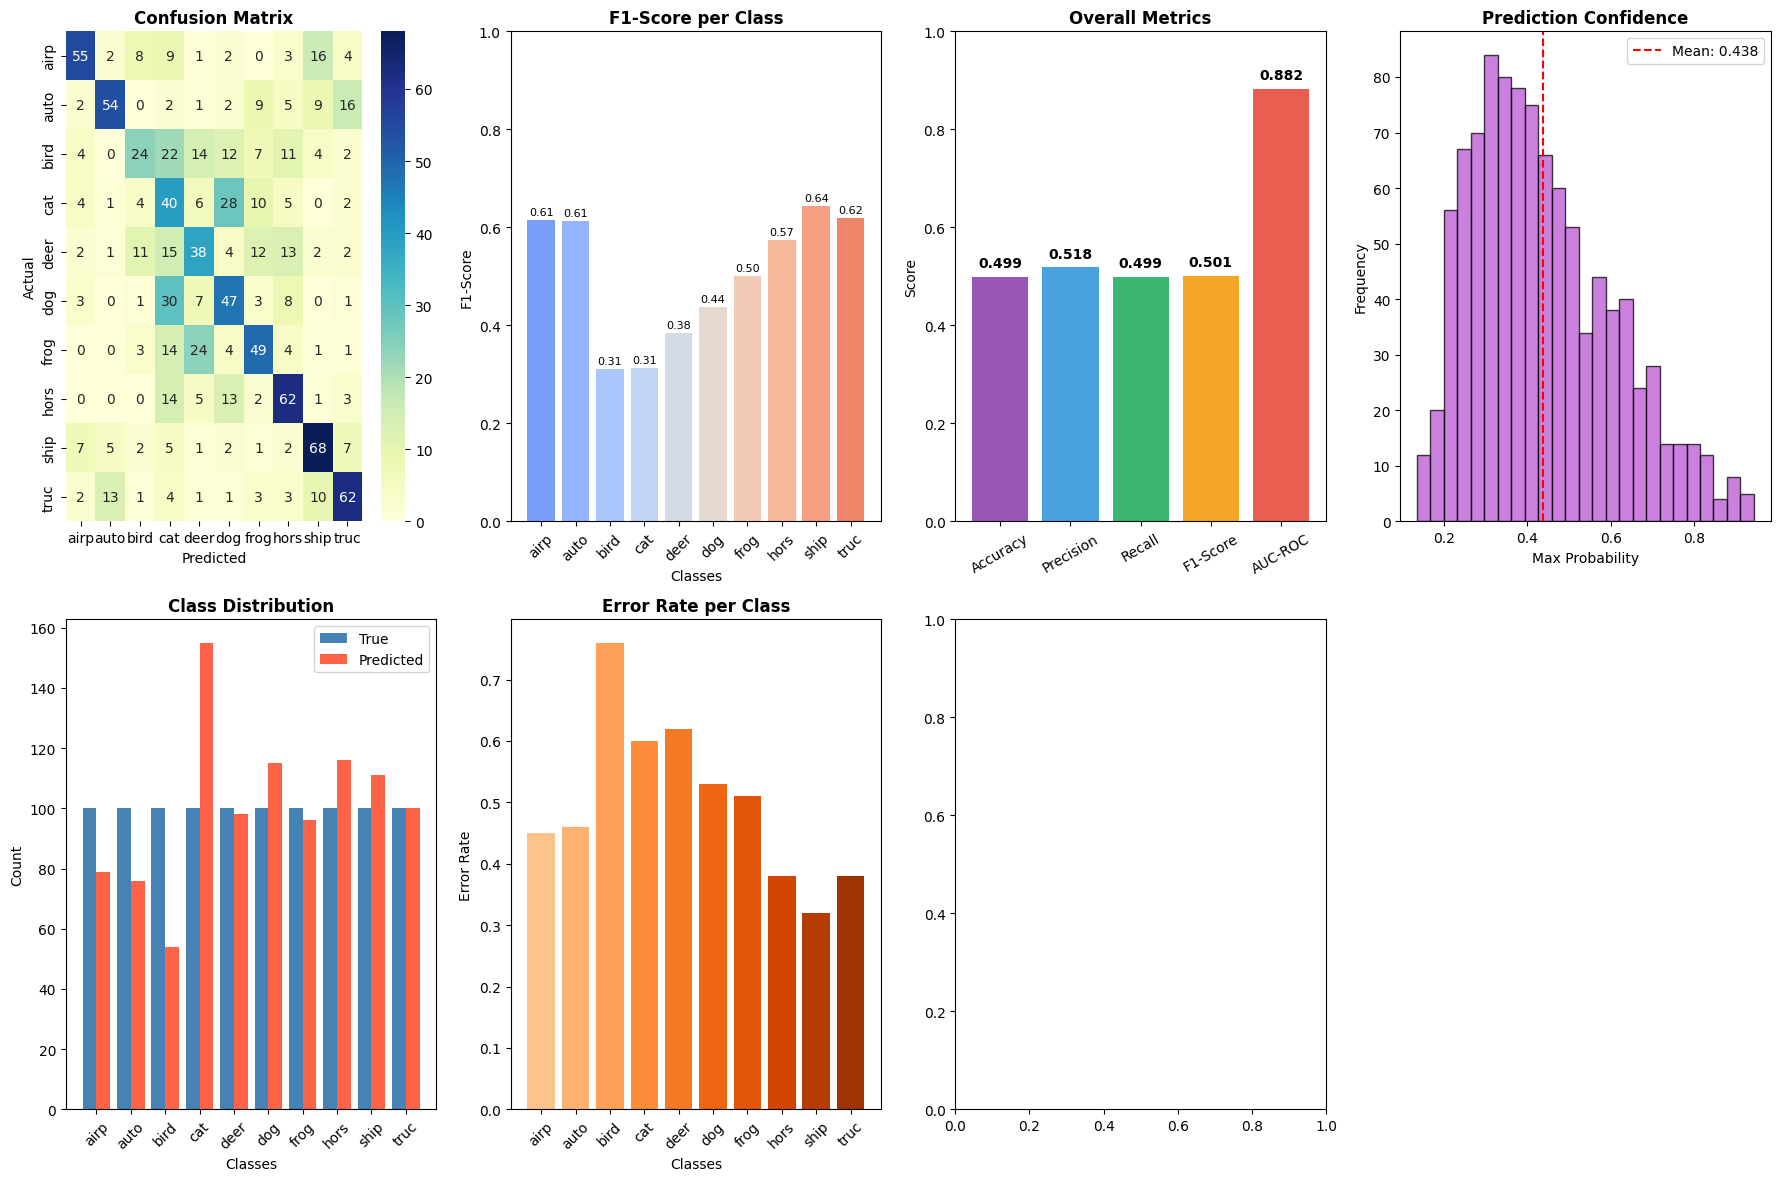

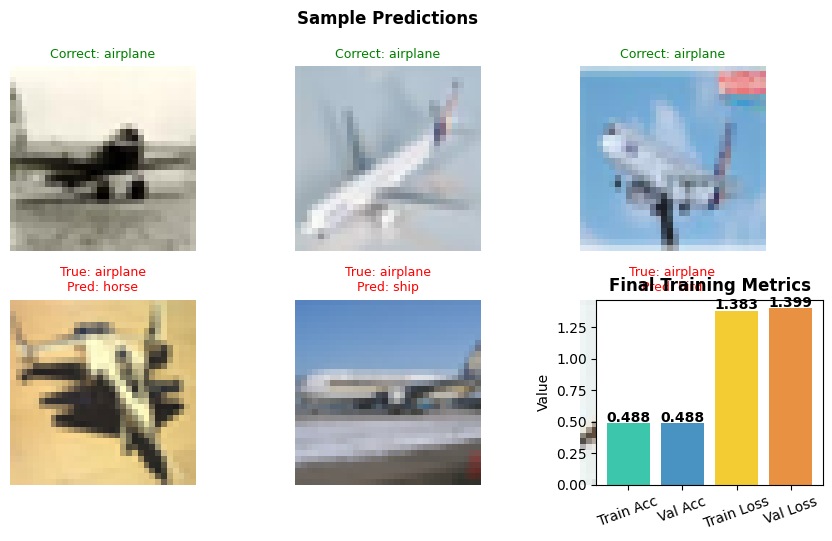

In [17]:
# Visualisasi Komprehensif Hasil Model CNN
plt.figure(figsize=(22, 14))

# 1️⃣ Confusion Matrix
plt.subplot(2, 4, 1)
cmatrix = confusion_matrix(y_test_flattened, y_pred_class)
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
            xticklabels=[label[:4] for label in class_names],
            yticklabels=[label[:4] for label in class_names])
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2️⃣ F1-Score per Class
plt.subplot(2, 4, 2)
class_report = classification_report(y_test_flattened, y_pred_class, target_names=class_names, output_dict=True)
f1_scores = [class_report[label]['f1-score'] for label in class_names]
colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(class_names)))
bars = plt.bar(range(len(class_names)), f1_scores, color=colors)
plt.title('F1-Score per Class', fontsize=12, fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.xticks(range(len(class_names)), [label[:4] for label in class_names], rotation=45)
plt.ylim(0, 1)

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.2f}', ha='center', fontsize=8)

# 3️⃣ Metrics Overview
plt.subplot(2, 4, 3)
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metric_values = list(eval_metrics.values())
colors = ['#8E44AD', '#3498DB', '#27AE60', '#F39C12', '#E74C3C']
bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.9)
plt.title('Overall Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)

for bar, val in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontweight='bold')

plt.xticks(rotation=30)

# 4️⃣ Prediction Confidence Distribution
plt.subplot(2, 4, 4)
conf_values = np.max(y_proba_pred, axis=1)
plt.hist(conf_values, bins=25, color='mediumorchid', edgecolor='black', alpha=0.75)
plt.axvline(np.mean(conf_values), color='red', linestyle='--',
            label=f'Mean: {np.mean(conf_values):.3f}')
plt.title('Prediction Confidence', fontsize=12, fontweight='bold')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.legend()

# 5️⃣ True vs Predicted Class Distribution
plt.subplot(2, 4, 5)
x_range = np.arange(len(class_names))
true_dist = np.bincount(y_test_flattened, minlength=10)
pred_dist = np.bincount(y_pred_class, minlength=10)

bar_width = 0.4
plt.bar(x_range - bar_width/2, true_dist, bar_width, label='True', color='steelblue')
plt.bar(x_range + bar_width/2, pred_dist, bar_width, label='Predicted', color='tomato')
plt.title('Class Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(x_range, [label[:4] for label in class_names], rotation=45)
plt.legend()

# 6️⃣ Error Rate per Class
plt.subplot(2, 4, 6)
errors_mask = (y_test_flattened != y_pred_class)
error_rate_per_class = []
for i in range(10):
    mask = (y_test_flattened == i)
    if np.sum(mask) > 0:
        rate = np.sum(errors_mask[mask]) / np.sum(mask)
        error_rate_per_class.append(rate)
    else:
        error_rate_per_class.append(0)

colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(class_names)))
bars = plt.bar(range(len(class_names)), error_rate_per_class, color=colors)
plt.title('Error Rate per Class', fontsize=12, fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Error Rate')
plt.xticks(range(len(class_names)), [label[:4] for label in class_names], rotation=45)

# 7️⃣ Sample Correct & Incorrect Predictions
plt.subplot(2, 4, 7)
correct_idx = np.where(y_test_flattened == y_pred_class)[0][:3]
incorrect_idx = np.where(y_test_flattened != y_pred_class)[0][:3]

fig_samp, axs = plt.subplots(2, 3, figsize=(9, 5))
for i, idx in enumerate(correct_idx):
    axs[0, i].imshow(X_test[idx])
    axs[0, i].set_title(f'Correct: {class_names[y_test_flattened[idx]]}', fontsize=9, color='green')
    axs[0, i].axis('off')

for i, idx in enumerate(incorrect_idx):
    axs[1, i].imshow(X_test[idx])
    axs[1, i].set_title(f'True: {class_names[y_test_flattened[idx]]}\nPred: {class_names[y_pred_class[idx]]}',
                        fontsize=9, color='red')
    axs[1, i].axis('off')

fig_samp.suptitle('Sample Predictions', fontsize=12, fontweight='bold')
plt.tight_layout()

# 8️⃣ Final Training Metrics Summary
plt.subplot(2, 4, 8)
final_acc_train = training_history.history['accuracy'][-1]
final_acc_val = training_history.history['val_accuracy'][-1]
final_loss_train = training_history.history['loss'][-1]
final_loss_val = training_history.history['val_loss'][-1]

summary_labels = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']
summary_values = [final_acc_train, final_acc_val, final_loss_train, final_loss_val]
colors_sum = ['#1ABC9C', '#2980B9', '#F1C40F', '#E67E22']

bars = plt.bar(summary_labels, summary_values, color=colors_sum, alpha=0.85)
plt.title('Final Training Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Value')

for bar, val in zip(bars, summary_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', fontweight='bold')

plt.xticks(rotation=20)

# Final layout
plt.tight_layout()
plt.show()


In [19]:
# Cari metrik terbaik
top_metric = max(eval_metrics.items(), key=lambda item: item[1])
print("\n=== BEST METRIC ===")
print(f"{top_metric[0].upper()} : {top_metric[1]:.4f}")

# Kategori performa keseluruhan
if top_metric[1] > 0.85:
    overall_performance = "EXCELLENT"
elif top_metric[1] > 0.75:
    overall_performance = "GOOD"
elif top_metric[1] > 0.65:
    overall_performance = "FAIR"
else:
    overall_performance = "NEEDS IMPROVEMENT"

print(f"\n=== OVERALL PERFORMANCE ===")
print(f"{overall_performance}")

# Analisis detail
print(f"\n=== DETAILED ANALYSIS ===")
print(f"Accuracy  : {acc_score:.1%} pada data uji")
print(f"Precision : {prec_score:.3f} (kualitas prediksi positif)")
print(f"Recall    : {rec_score:.3f} (cakupan positif sebenarnya)")
print(f"F1-Score  : {f1_score_val:.3f} (keseimbangan precision dan recall)")
print(f"AUC-ROC   : {roc_auc_val:.3f} (kemampuan pemeringkatan probabilitas)")

# Rekomendasi
print(f"\n=== RECOMMENDATIONS ===")
if acc_score < 0.8:
    print("- Pertimbangkan peningkatan kompleksitas model atau menambah jumlah epoch.")
if f1_score_val < acc_score:
    print("- Cek kemungkinan imbalance kelas; gunakan weighted loss atau augmentasi data.")
if roc_auc_val > 0.85:
    print("- Kalibrasi probabilitas model sudah baik.")
if abs(final_acc_train - final_acc_val) > 0.1:
    print("- Perhatikan indikasi overfitting; pertimbangkan regularisasi tambahan.")

# Status untuk deployment
print(f"\n=== DEPLOYMENT STATUS ===")
if acc_score > 0.8 and abs(final_acc_train - final_acc_val) < 0.1:
    print("MODEL SIAP UNTUK DEPLOYMENT")
else:
    print("MODEL MASIH MEMERLUKAN PENINGKATAN SEBELUM DEPLOYMENT")



=== BEST METRIC ===
AUC_ROC : 0.8822

=== OVERALL PERFORMANCE ===
EXCELLENT

=== DETAILED ANALYSIS ===
Accuracy  : 49.9% pada data uji
Precision : 0.518 (kualitas prediksi positif)
Recall    : 0.499 (cakupan positif sebenarnya)
F1-Score  : 0.501 (keseimbangan precision dan recall)
AUC-ROC   : 0.882 (kemampuan pemeringkatan probabilitas)

=== RECOMMENDATIONS ===
- Pertimbangkan peningkatan kompleksitas model atau menambah jumlah epoch.
- Kalibrasi probabilitas model sudah baik.

=== DEPLOYMENT STATUS ===
MODEL MASIH MEMERLUKAN PENINGKATAN SEBELUM DEPLOYMENT
